# Описание проекта

Цель: Оператору связи необходимо научисться прогнозировать отток клиентов для планирования предиктивных мер (скидок, особых условий).


* Основная метрика для проверки качества модели: roc_auc
* Дополнительная метрика: accuracy



## Данные

**Целевой признак**

* Churn — уход клиента (Да или Нет)

**Услуги которые могут быть у клиента**
* PhoneService — Есть ли у клиента телефонная служба (Да, Нет)
* MultipleLines — Есть ли у клиента несколько линий (Да, Нет, Нет телефонной связи)
* InternetService — Интернет-провайдер Клиента (DSL, оптоволокно, Нет)
* OnlineSecurity — Есть ли у клиента онлайн-безопасность (Да, Нет, Нет интернет-сервиса)
* OnlineBackup — Есть ли у клиента онлайн-резервная копия (Да, Нет, Нет интернет-службы)
* DeviceProtection — Есть ли у клиента защита устройства (Да, Нет, Нет интернет-сервиса)
* TechSupport — Есть ли у клиента техническая поддержка (Да, Нет, Нет интернет-сервиса)
* StreamingTV — Есть ли у клиента потоковое(стриминговое) телевидение (Да, Нет, Нет интернета)
* StreamingMovies — Есть ли у клиента потоковые фильмы (Да, Нет, Нет интернет-сервиса)

**Информация о счете клиента**
* Tenure — Количество месяцев, в течение которых клиент оставался в компании
* Contract — Срок действия договора заказчика (от месяца к месяцу, Один год, два года)
* PaperlessBilling — Есть ли у клиента безбумажный биллинг (Да, Нет)
* PaymentMethod — Способ оплаты клиента (Электронный чек, Отправленный по почте чек, Банковский перевод (автоматический), Кредитная карта (автоматическая))
* MonthlyCharges — Сумма, взимаемая с клиента ежемесячно
* TotalCharges — Общая сумма, взимаемая с клиента

**Демографическая информация о клиенте**
* customerID — Customer ID
* Gender — Является ли клиент мужчиной или женщиной
* SeniorCitizen — Является ли клиент пожилым гражданином или нет (1, 0)
* Partner — есть ли у клиента партнер или нет (Да, Нет)
* Dependents — Независимо от того, есть ли у клиента иждивенцы или нет (Да, Нет)

# 1. Первичный анализ, преобразование и очистка данных

## 1.1 загрузка данных

In [2]:
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 69.2MB 67kB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.special import softmax
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, recall_score, precision_score
from tqdm.autonotebook import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


## 1.2 Предобработка данных

In [5]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [6]:
df['gender'] = df['gender'].replace(['Male', 'Female'], [1,0])
df.drop('customerID', axis=1, inplace=True)
df = df.loc[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype('float64')

In [7]:
for col in ['PaperlessBilling','PhoneService','MultipleLines','Dependents','Partner','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn']:
    df[col] = (df[col] == 'Yes').astype('int8')

In [8]:
def transform_type(ptype):
    if ptype == 'Month-to-month' :
        res = 0
    elif ptype == 'One year' :
        res = 1
    elif ptype == 'Two year' :
        res = 2
    return res
df['Contract'] = df['Contract'].apply(transform_type).astype('int8')

In [9]:
def transform_payment_method(pmethod):
    if pmethod == 'Electronic check' :
        res = 0
    elif pmethod == 'Mailed check' :
        res = 1
    elif pmethod == 'Bank transfer (automatic)' :
        res = 2
    elif pmethod == 'Credit card (automatic)' :
        res = 3
    return res
df['PaymentMethod'] = df['PaymentMethod'].apply(transform_payment_method).astype('int8')

In [10]:
def transform_InternetService(internet):
    if internet == 'DSL' :
        res = 0
    elif internet == 'Fiber optic' :
        res = 1
    elif internet == 'No' :
        res = 2
    return res
df['InternetService'] = df['InternetService'].apply(transform_InternetService).astype('int8')

In [11]:
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int8   
 3   Dependents        7032 non-null   int8   
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int8   
 6   MultipleLines     7032 non-null   int8   
 7   InternetService   7032 non-null   int8   
 8   OnlineSecurity    7032 non-null   int8   
 9   OnlineBackup      7032 non-null   int8   
 10  DeviceProtection  7032 non-null   int8   
 11  TechSupport       7032 non-null   int8   
 12  StreamingTV       7032 non-null   int8   
 13  StreamingMovies   7032 non-null   int8   
 14  Contract          7032 non-null   int8   
 15  PaperlessBilling  7032 non-null   int8   
 16  PaymentMethod     7032 non-null   int8   


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,1,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,70.70,151.65,1
5,0,0,0,0,8,1,1,1,0,0,1,0,1,1,0,1,0,99.65,820.50,1
6,1,0,0,1,22,1,1,1,0,1,0,0,1,0,0,1,3,89.10,1949.40,0
7,0,0,0,0,10,0,0,0,1,0,0,0,0,0,0,0,1,29.75,301.90,0
8,0,0,1,0,28,1,1,1,0,0,1,1,1,1,0,1,0,104.80,3046.05,1
9,1,0,0,1,62,1,0,0,1,1,0,0,0,0,1,0,2,56.15,3487.95,0


## 1.3 Анализ данных и отбор признаков

In [12]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.421928,0.872582,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.688567,0.592719,1.315557,64.798208,2283.300441,0.265785
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.493902,0.737271,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.832934,0.491363,1.149523,30.085974,2266.771362,0.441782
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.587500,401.450000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


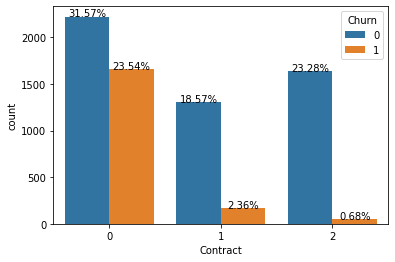

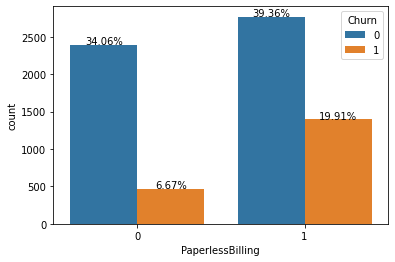

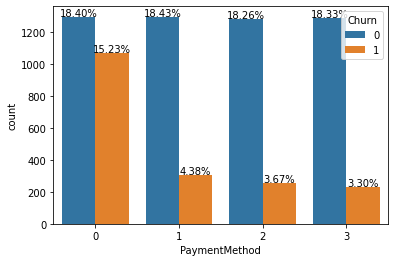

In [13]:
prec = ['Contract',	'PaperlessBilling','PaymentMethod']
for i in prec:
  ax = sns.countplot(x=i, hue="Churn", data=df)
  for p in ax.patches:    
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:.2%}'.format(height/(len(df))),
              ha="center") 
  plt.show()

Около половины пользователей предпочитает долгосрочный контракт (1-2 года), 60% пользователей выбирают электронные чеки вместо бумажных. 88% ушедших пользователей пользовались 'Month-to-month' контактом. Можно сделать промежутный вывод, что у тех пользоателей, которые заключают долгосрочный контракт вероятность ухода меньше.

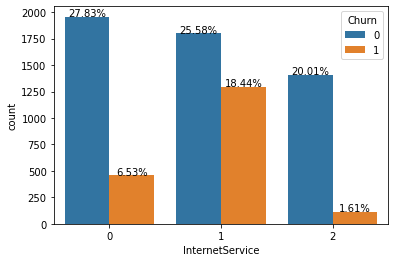

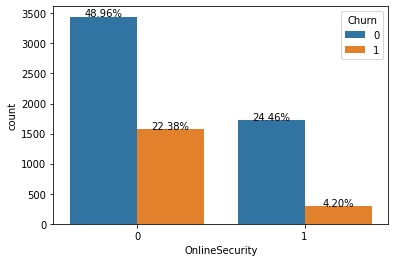

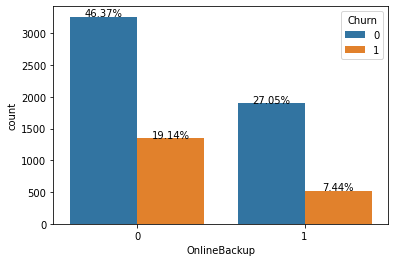

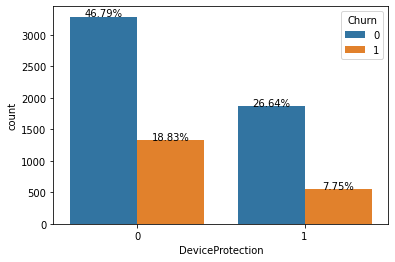

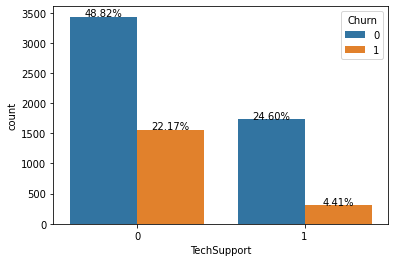

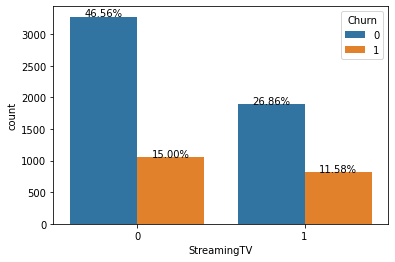

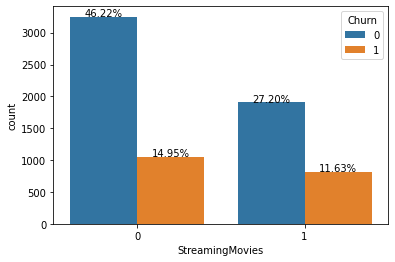

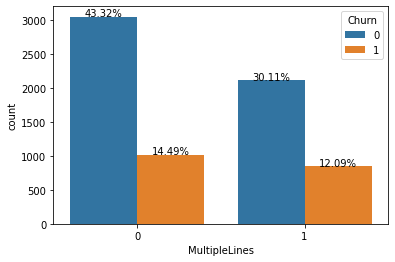

In [14]:
prec = ['InternetService',	'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
for i in prec:
  ax = sns.countplot(x=i, hue="Churn", data=df)
  for p in ax.patches:    
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:.2%}'.format(height/(len(df))),
              ha="center") 
  plt.show()

Наиболее востребованные услуги: Streaming TV/Movies; Наименее востребованные услуги: TechSupport и Online security. Сильных различий по услугам между всеми и ушедшеми пользователями не обнаружено.

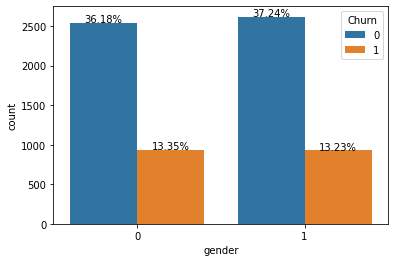

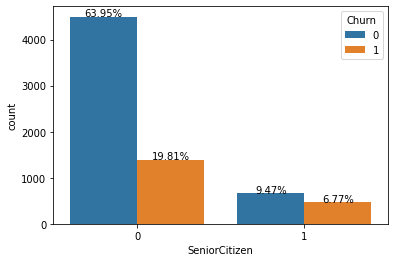

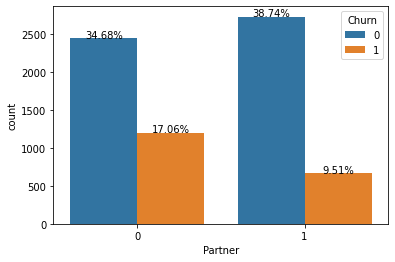

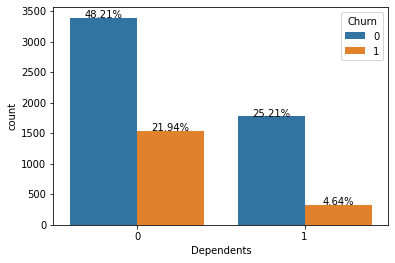

In [15]:
prec = ['gender',	'SeniorCitizen','Partner','Dependents']
for i in prec:
  ax = sns.countplot(x=i, hue="Churn", data=df)
  for p in ax.patches:    
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:.2%}'.format(height/(len(df))),
              ha="center") 
  plt.show()

Услугами одинаково часто пользуются как мужчины так и женщины; 16% пользователей - пожилые люди; у 30% пользователей есть дети. Неженатые/незамужние занимают долю 64% в ушедших пользователях, при том что в общем количестве они занимают 52%.

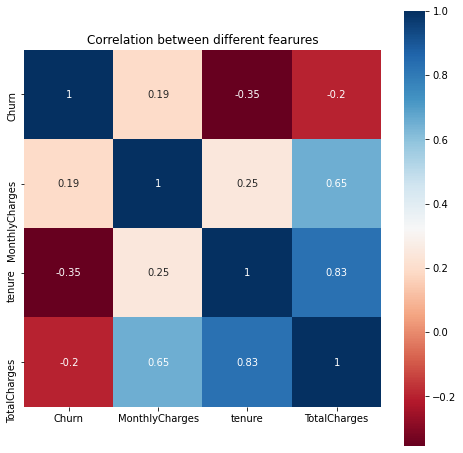

In [16]:
# Построим матрицу корреляции для количественных признаков
cor_columns = ['Churn', 'MonthlyCharges', 'tenure','TotalCharges']
correlation = df[cor_columns].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation, vmax=1, square=True, annot=True,cmap='RdBu')

plt.title('Correlation between different fearures')
plt.show()

Высокая корреляция наблюдается у признаков tenure и TotalCharges. Признаки TotalCharges и MonthlyCharges тоже сильно коррелируют.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


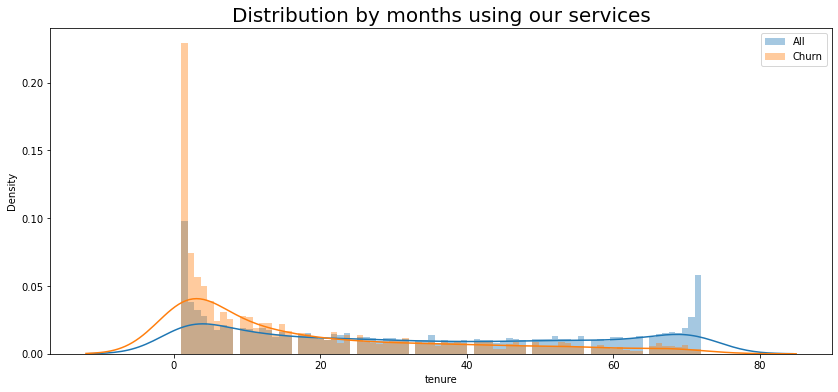

In [17]:
plt.figure(figsize = (14, 6))
sns.distplot(df['tenure'], label='All', bins=80)
sns.distplot(df[df['Churn'] == 1]['tenure'], label='Churn', bins=80)
plt.title('Distribution by months using our services', fontsize=20)
plt.legend();


Чем дольше клиент пользуется нашими услугами, тем меньше вероятность его ухода. Основная масса уходящих, уходят в течении 20 месяцев (66%). 20% от ушедших пользовались услугами лишь один месяц.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


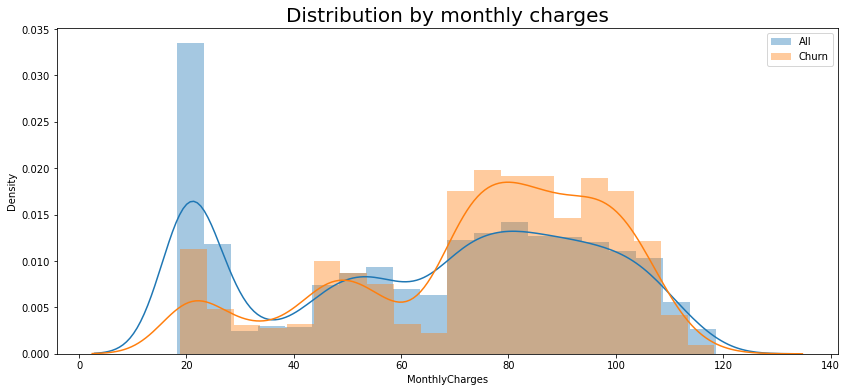

In [18]:
plt.figure(figsize = (14, 6))
sns.distplot(df['MonthlyCharges'], label='All', bins=20)
sns.distplot(df[df['Churn'] == 1]['MonthlyCharges'], label='Churn', bins=20)
plt.title('Distribution by monthly charges', fontsize=20)
plt.legend();

Чем меньше размер ежемесячного платежа у клиента, тем меньше вероятность его ухода. 72% ушедших платили в месяц свыше 65. Среднемесячный платеж по оставшимся пользователям составляет 61, а по ушедшим 74.

## Выводы
* Данные успешно загружены и обработаны. Большие выбросы сред данных отсутствуют. Строковые типы преобразованы к числовым категориям.
* Проведён анализ признаков.
* в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся
* многие ушедшие клиенты расплачивались методом 'Electronic check'
* большинство ушедших клиентов были подключены по оптоволокну.
среди клиентов, не пользовавшихся услугами интернета (fiber_optic = -1), отток сравнительно небольшой
* Построена матрица корреляции и отобраны наиболее релевантные для модели признаки

# 2. Выбор и обучение модели

In [19]:
df['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

Отношение ушедших клиентов к оставшимся в выборке примерно 3:1. Нет необходимости искусственно изменять это соотношение с помощью upsampling, но при разделении данных на train-validation-test надо учесть это соотношение.

In [20]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [21]:
# Разделим данные на тренировочную и тестовую выборку в соотношении 4:1. При разделении учтем баланс классов целевого признака.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (5625, 19)
Размер тестовой выборки: (1407, 19)


**Масштабируем количественные признаки**

In [23]:
quantitive_columns = ['MonthlyCharges','TotalCharges','tenure']
display(X_train[quantitive_columns].head(2))
display(X_test[quantitive_columns].head(2))

,MonthlyCharges,TotalCharges,tenure
1413,94.55,6078.75,65
7003,35.75,1022.50,26


,MonthlyCharges,TotalCharges,tenure
974,75.95,4542.35,59
619,78.55,522.95,7


In [24]:
scaler = StandardScaler()

warnings.filterwarnings('ignore')
X_train.loc[:, quantitive_columns] = scaler.fit_transform(X_train.loc[:, quantitive_columns])
X_test.loc[:, quantitive_columns] = scaler.transform(X_test.loc[:, quantitive_columns])
warnings.filterwarnings('default')

In [25]:
display(X_train[quantitive_columns].head(2))
display(X_test[quantitive_columns].head(2))

,MonthlyCharges,TotalCharges,tenure
1413,0.981556,1.659900,1.321816
7003,-0.971546,-0.562252,-0.267410


,MonthlyCharges,TotalCharges,tenure
974,0.363738,0.984674,1.077320
619,0.450100,-0.781798,-1.041649


Целевой признак ухода представлен в меньшей степени. Многие модели умеют работать с дисбалансом, но пойдем по другому пути. Чтобы сбаллансировать классы и увеличить количество данных, напишем функцию upsample(features, target, repeat) для формирования сблалансированной выборки:

In [26]:
""" def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = repeat
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled """

' def upsample(features, target, repeat):\n\n    features_zeros = features[target == 0]\n    features_ones = features[target == 1]\n    target_zeros = target[target == 0]\n    target_ones = target[target == 1]\n\n    repeat = repeat\n    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)\n    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)\n    \n    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)\n    return features_upsampled, target_upsampled '

In [27]:
""" X_train_ups, y_train_ups = upsample(X_train, y_train, 3)

print(X_train_ups.shape)
print(y_train_ups.shape) """

' X_train_ups, y_train_ups = upsample(X_train, y_train, 3)\n\nprint(X_train_ups.shape)\nprint(y_train_ups.shape) '

In [28]:
""" scale_pos_weight = round((len(y_train_ups[y_train_ups == 0]) / 
                          len(y_train_ups[y_train_ups == 1])), 3)
scale_pos_weight """

' scale_pos_weight = round((len(y_train_ups[y_train_ups == 0]) / \n                          len(y_train_ups[y_train_ups == 1])), 3)\nscale_pos_weight '

**Base-line модель**

In [29]:
pred_bl = [0] * y.shape[0]
roc_auc_bl = roc_auc_score(y.values, pred_bl)
print(f"roc_auc для константной модели: {roc_auc_bl:.3f}")
accuracy_bl = accuracy_score(y.values, pred_bl)
print(f"accuracy для константной модели: {accuracy_bl:.3f}")

roc_auc для константной модели: 0.500
accuracy для константной модели: 0.734



Для подбора гиперпараметров будем использовать **GridSearchCV**, для кросс-валидации при подборе гиперпараметров **ShuffleSplit** с разбиеним на 3 фолда и оценке на 1/5 части выборки.

Напишем функцию *model_learning* - принимающая модель и сетку параметров, обучает и возвращает лучшую модель на обучениии.

In [30]:
def model_learning(model, parameters):
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=12345)
    grid_model = GridSearchCV(model, parameters, scoring='roc_auc', cv=cv)
    grid_model.fit(X_train, y_train)
    print('Лучшая оценка на валидации: ', grid_model.best_score_)
    print('Лучшие гиперпараметры модели на валидации: ', grid_model.best_params_)
    print('Лучшая модель: ', grid_model.best_estimator_)
    return grid_model.best_estimator_

Для оценки качества модели по ROC-AUC и Accuracy напишем функцию test_scoring, принимает обученную модель и дает оценки на тестовой выборке и строит ROC-AUC кривую:

In [31]:
def test_scoring(model):
    pred_proba_test = model.predict_proba(X_test)[:, 1]
    pred_test = model.predict(X_test)
    print('Accuracy: ', round(model.score(X_test, y_test), 3))
    print('Presicion: ', round(precision_score(y_test, pred_test), 3))
    print('Recall: ', round(recall_score(y_test, pred_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(y_test, pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)

    sns.set()
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()

Для оценки важности признаков напишем функцию feature_importance, принимающая обученную модель и выводящая признаки, ранжированные по значимости для модели:

In [32]:
def feature_importance(model):
    feats = {}
    for feature, importance in zip(X_train.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
    plt.xlabel('Важность', fontsize=25, weight = 'bold')
    plt.ylabel('Признаки', fontsize=25, weight = 'bold')
    plt.title('Важность признаков', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances)

**Logistic Regression**

коэффициент регулиризации С - ограничивает рост весов при признаках

Лучшая оценка на валидации:  0.8462677425164147
Лучшие гиперпараметры модели на валидации:  {'C': 0.5272631578947369}
Лучшая модель:  LogisticRegression(C=0.5272631578947369, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:  0.798
Presicion:  0.636
Recall:  0.561
AUC-ROC:  0.837


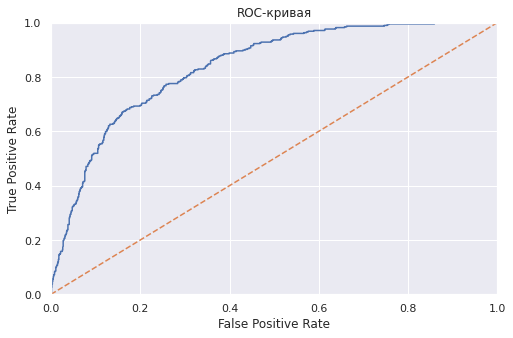

CPU times: user 1.28 s, sys: 2.89 s, total: 4.17 s
Wall time: 4.36 s


In [33]:
%%time
lr = LogisticRegression(random_state=12345, n_jobs=-1)
lr_param = {'C' : np.linspace(0.001, 10, 20)}

lr_fitted = model_learning(lr, lr_param)
test_scoring(lr_fitted)


Для модели важность признака определяется абсолютным значением его коэффициента.
Посчитаем долю влияния каждого признака на предсказание модели LogisticRegression, воспользуясь функцией softmax:

In [34]:
m = softmax(abs(lr_fitted.coef_))
m[0]

array([0.03341869, 0.03979721, 0.03315503, 0.04114333, 0.11679085,
       0.10785846, 0.0376828 , 0.033227  , 0.05875109, 0.04558543,
       0.0375284 , 0.0563949 , 0.03432858, 0.03535004, 0.06782988,
       0.04433165, 0.03719051, 0.08203677, 0.05759939])

У модели LogisticRegression нет метода featureimportances, воспользуемся готовым кодом и заменим значение на полученное выше

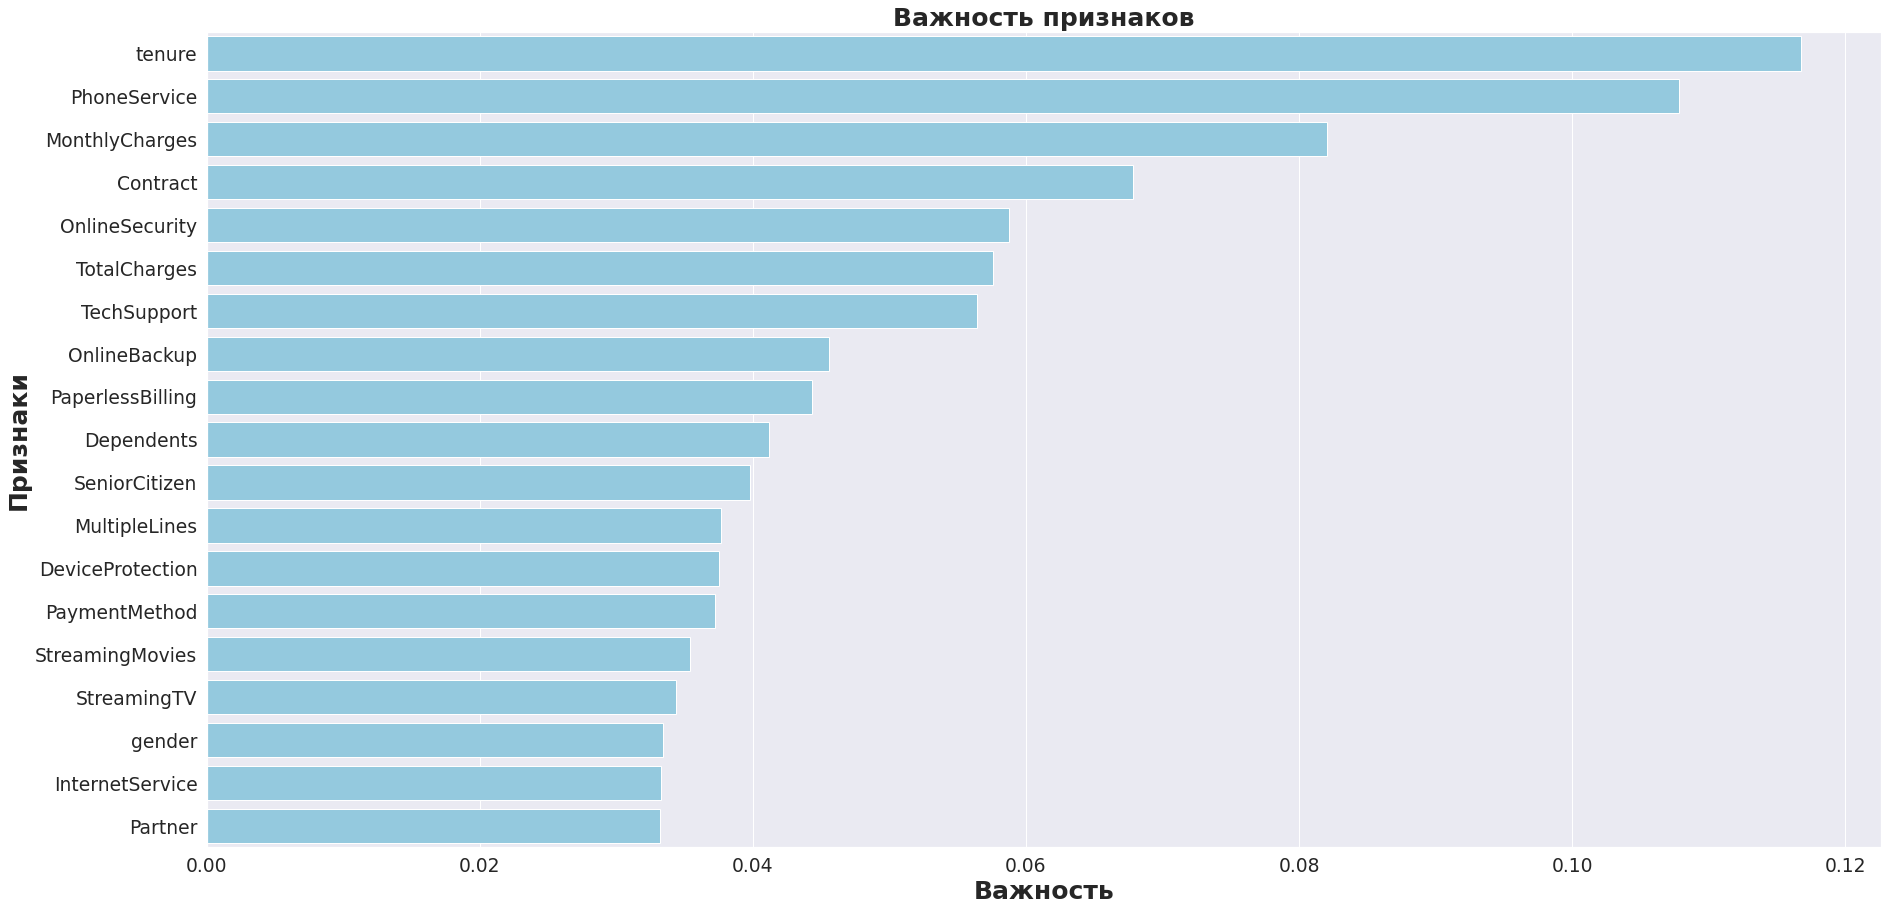

None

,Features,Gini-Importance
0,tenure,0.116791
1,PhoneService,0.107858
2,MonthlyCharges,0.082037
3,Contract,0.067830
4,OnlineSecurity,0.058751
5,TotalCharges,0.057599
6,TechSupport,0.056395
7,OnlineBackup,0.045585
8,PaperlessBilling,0.044332
9,Dependents,0.041143


In [35]:
feats = {}
for feature, importance in zip(X_train.columns, m[0]):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Важность', fontsize=25, weight = 'bold')
plt.ylabel('Признаки', fontsize=25, weight = 'bold')
plt.title('Важность признаков', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

**Лучшие гиперпараметры:**

* {'C': 0.5272631578947369}

**Метрики:**

* Accuracy: 0.798
* Presicion: 0.636
* Recall: 0.561
* AUC-ROC: 0.837


**Топ-5 важных признаков модели:**

* tenure
* PhoneService
* MonthlyCharges
* Contract
* OnlineSecurity



**Модель RandomForest**

Лучшая оценка на валидации:  0.850991510937365
Лучшие гиперпараметры модели на валидации:  {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}
Лучшая модель:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=-1, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
Accuracy:  0.797
Presicion:  0.65
Recall:  0.516
AUC-ROC:  0.836


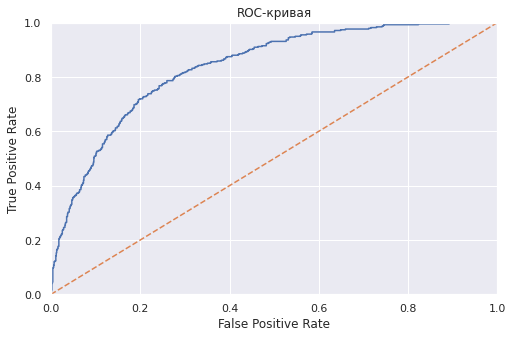

CPU times: user 1min 20s, sys: 7.08 s, total: 1min 27s
Wall time: 4min 21s


In [36]:
%%time
rf = RandomForestClassifier(random_state=12345, n_jobs=-1)
rf_param = {'n_estimators': [300, 500, 700],
            'max_depth': [None, 10, 15, 17],
            'max_features': [3, 5, 7],
            'min_samples_leaf': np.arange(2, 4, 6),
            'min_samples_split': np.arange(2, 4, 6)}

rf_fitted = model_learning(rf, rf_param)
test_scoring(rf_fitted)

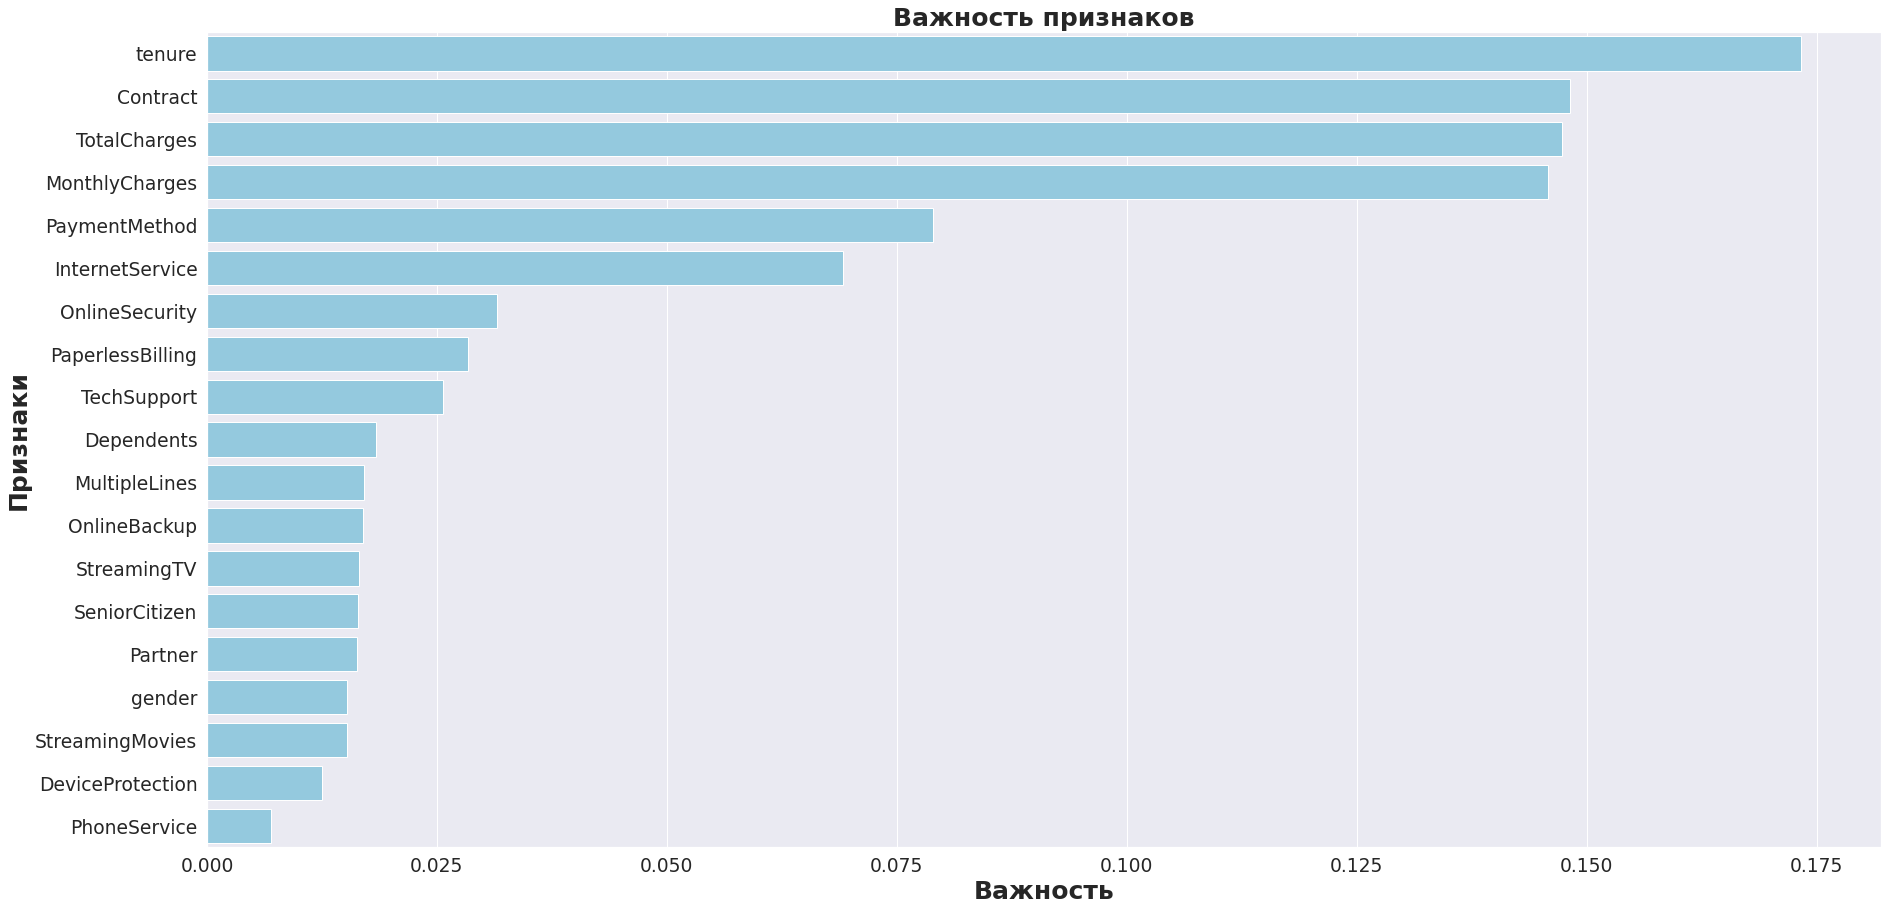

None

,Features,Gini-Importance
0,tenure,0.173321
1,Contract,0.148181
2,TotalCharges,0.147350
3,MonthlyCharges,0.145785
4,PaymentMethod,0.078960
5,InternetService,0.069134
6,OnlineSecurity,0.031504
7,PaperlessBilling,0.028410
8,TechSupport,0.025631
9,Dependents,0.018415


In [37]:
feature_importance(rf_fitted)

**Лучшие гиперпараметры:**

* {'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}

**Метрики:**

* Accuracy: 0.797
* Presicion: 0.65
* Recall: 0.516
* AUC-ROC: 0.836

**Топ-5 важных признаков модели:**

* tenure
* Contract
* TotalCharges
* MonthlyCharges
* PaymentMethod

Разница между LogisticRegression и RandomForestClassifier по метрике ROC-AUC практически отсутствует, но скорость обучения логистической регрессии несоизмеримо выше, что и логично она же одна.

**Модели градиентного бустинга**

**CatBoost**

Подбор параметров:

* n_estimators - количество решающих деревьев
* learning_rate - коэффициент шага антиградиента
* max_depth - глубина дерева
* l2_leaf_reg - коеффициент при l2 регуризации


Лучшая оценка на валидации:  0.8538779108328581
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Лучшая модель:  <catboost.core.CatBoostClassifier object at 0x7fb9341ec310>
Accuracy:  0.798
Presicion:  0.667
Recall:  0.481
AUC-ROC:  0.84


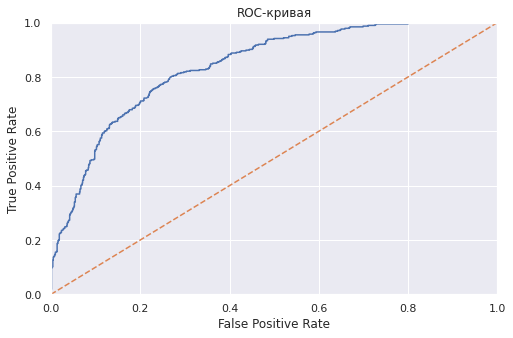

CPU times: user 14min 43s, sys: 39.5 s, total: 15min 23s
Wall time: 9min 3s


In [45]:
%%time
CatBoost_clf = CatBoostClassifier(random_state=12345, verbose=0)
CatBoost_clf_param = {'n_estimators': [300, 500, 700, 900],
                      'learning_rate': [0.01, 0.1, 1],
                      'max_depth': [1, 5, 9],
                      'l2_leaf_reg': [1, 3]}

CatBoost_fitted = model_learning(CatBoost_clf, CatBoost_clf_param)
test_scoring(CatBoost_fitted)

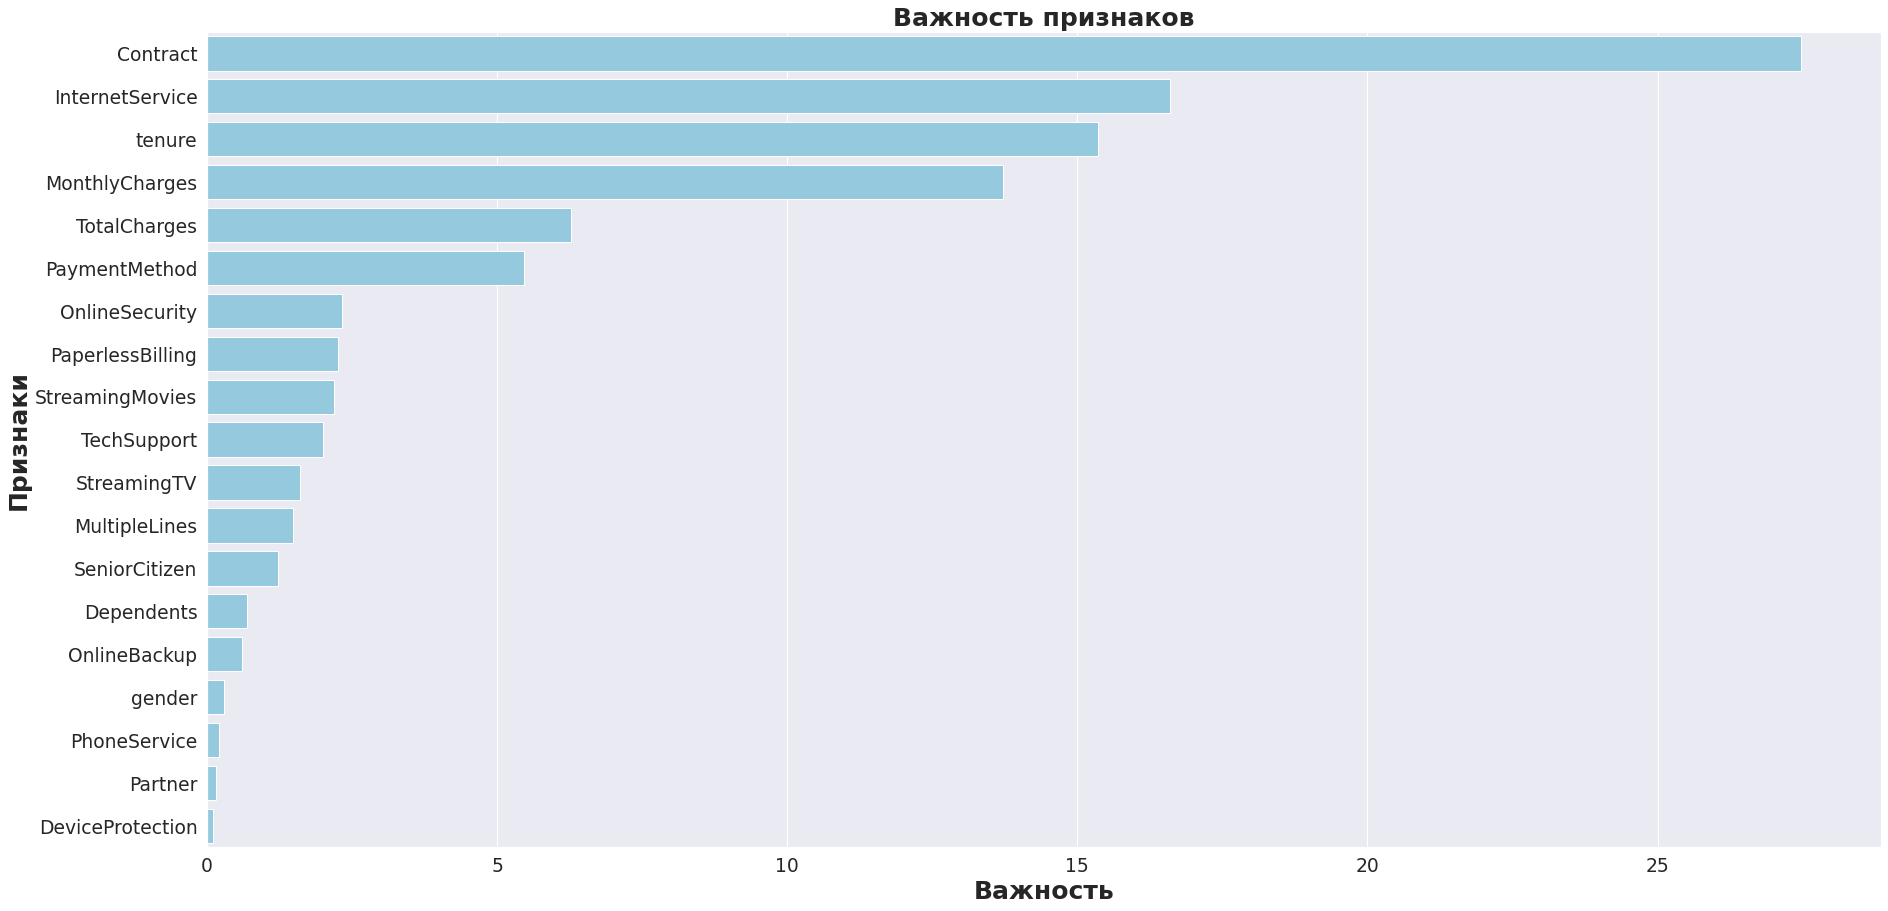

None

,Features,Gini-Importance
0,Contract,27.474985
1,InternetService,16.598451
2,tenure,15.347927
3,MonthlyCharges,13.717939
4,TotalCharges,6.266887
5,PaymentMethod,5.465168
6,OnlineSecurity,2.322774
7,PaperlessBilling,2.264262
8,StreamingMovies,2.184772
9,TechSupport,1.999834


In [46]:
feature_importance(CatBoost_fitted)

**Лучшие гиперпараметры:**

* {'l2_leaf_reg': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

**Метрики:**

* Accuracy: 0.798
* Presicion: 0.667
* Recall: 0.481
* AUC-ROC: 0.84

**Топ-5 важных признаков модели:**

* Contract
* InternetService	
* tenure
* MonthlyCharges
* TotalCharges

**XGBoost**

Лучшая оценка на валидации:  0.8530210961230636
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}
Лучшая модель:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, l2_leaf_reg=1,
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=12345,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy:  0.799
Presicion:  0.648
Recall:  0.532
AUC-ROC:  0.84


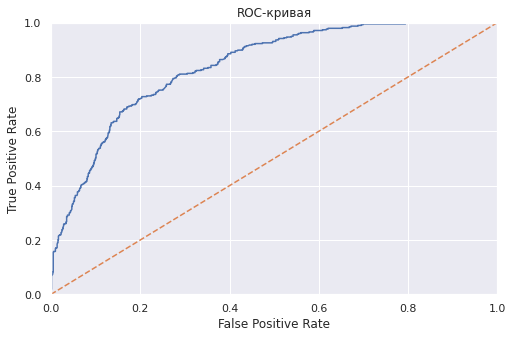

CPU times: user 11min 54s, sys: 2.58 s, total: 11min 57s
Wall time: 6min 3s


In [40]:
%%time
xgb_clf = XGBClassifier(random_state=12345, n_jobs=-1)
xgb_clf_param = {'n_estimators': [300, 500, 700, 900],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 5, 9],
                  'l2_leaf_reg': [1, 3]}

xgb_clf_fitted = model_learning(xgb_clf, xgb_clf_param)
test_scoring(xgb_clf_fitted)

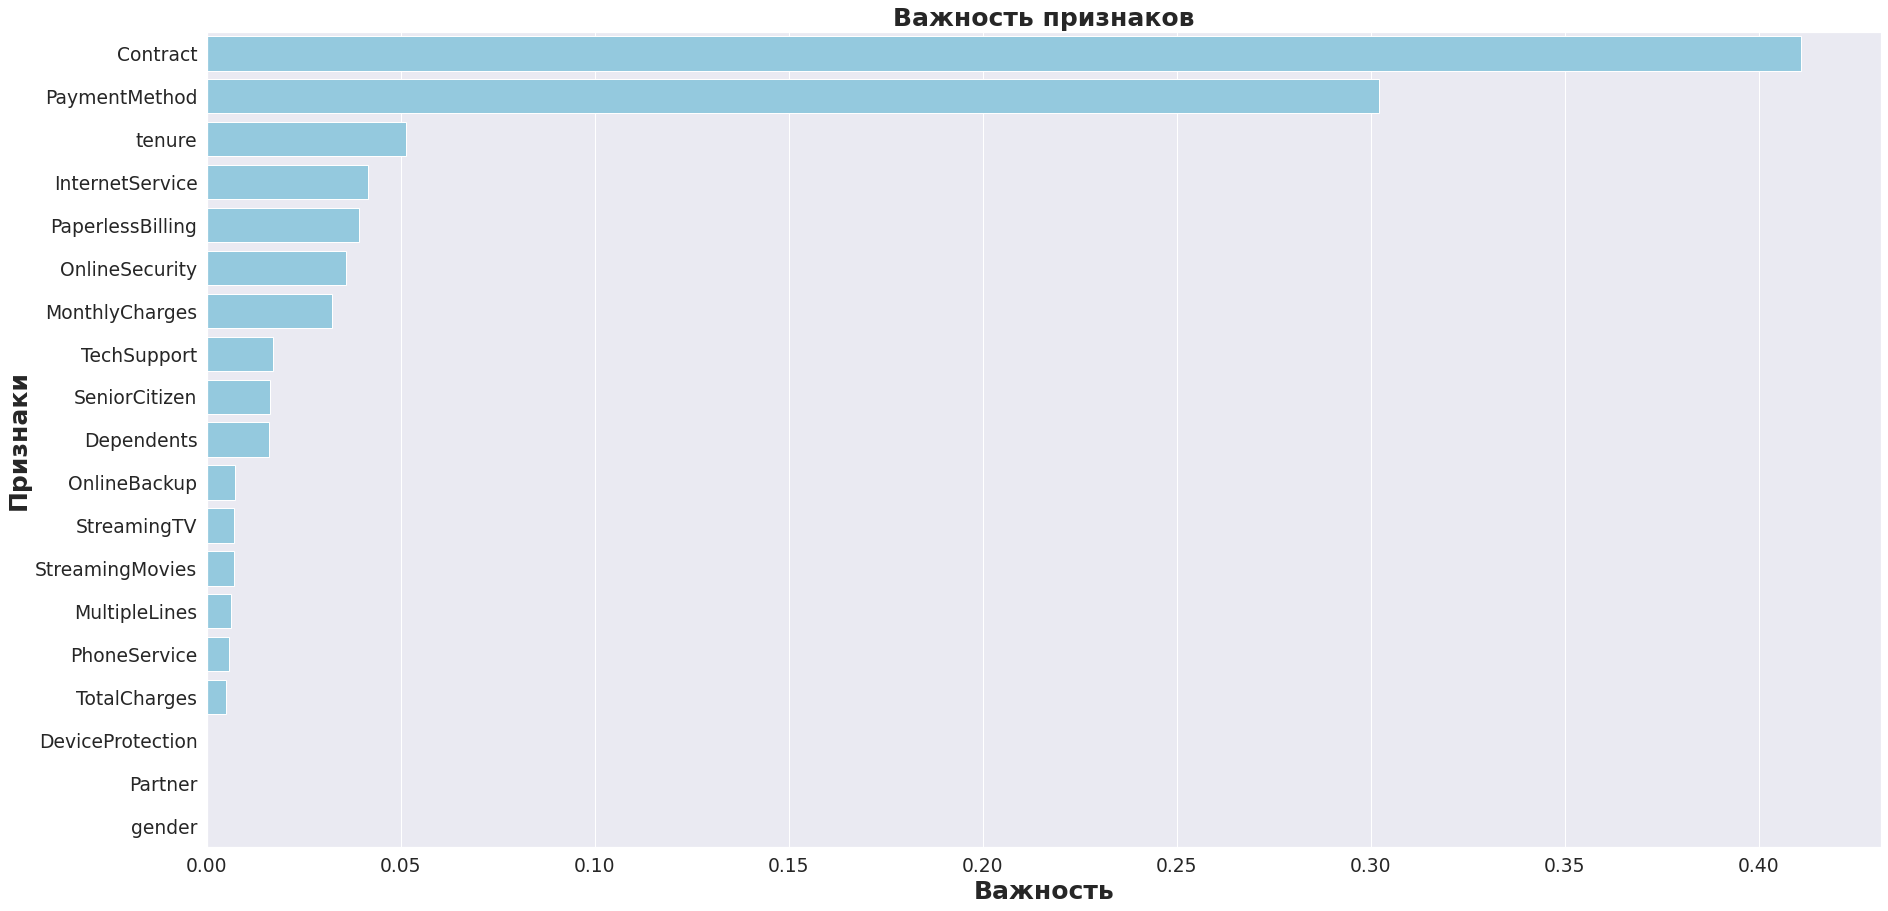

None

,Features,Gini-Importance
0,Contract,0.410929
1,PaymentMethod,0.302137
2,tenure,0.051356
3,InternetService,0.041443
4,PaperlessBilling,0.039151
5,OnlineSecurity,0.035766
6,MonthlyCharges,0.032262
7,TechSupport,0.016915
8,SeniorCitizen,0.016256
9,Dependents,0.016088


In [41]:
feature_importance(xgb_clf_fitted)

**Лучшие гиперпараметры:**

* {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}

**Метрики:**

* Accuracy: 0.799
* Presicion: 0.648
* Recall: 0.532
* AUC-ROC: 0.84

**Топ-5 важных признаков модели:**

* Contract
* PaymentMethod
* tenure
* InternetService
* PaperlessBilling

**LGBM**

Лучшая оценка на валидации:  0.8530304295564951
Лучшие гиперпараметры модели на валидации:  {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}
Лучшая модель:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', l2_leaf_reg=1, learning_rate=0.1,
               max_depth=1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
               objective=None, random_state=12345, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
Accuracy:  0.795
Presicion:  0.64
Recall:  0.527
AUC-ROC:  0.84


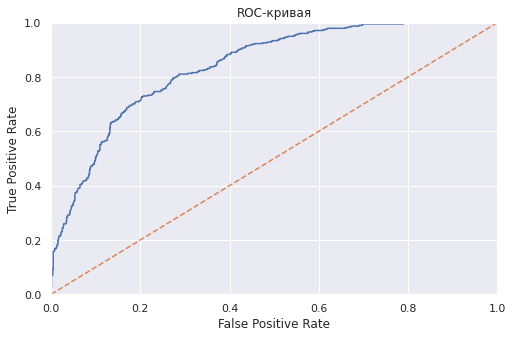

CPU times: user 1min 50s, sys: 2.85 s, total: 1min 53s
Wall time: 58 s


In [52]:
%%time
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=12345)
lgbm_clf_param = {'n_estimators': [300, 500, 700],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [1, 3, 5],
                  'l2_leaf_reg': [1, 3]}
    
lgbm_clf_fitted = model_learning(lgbm_clf, lgbm_clf_param)
test_scoring(lgbm_clf_fitted)

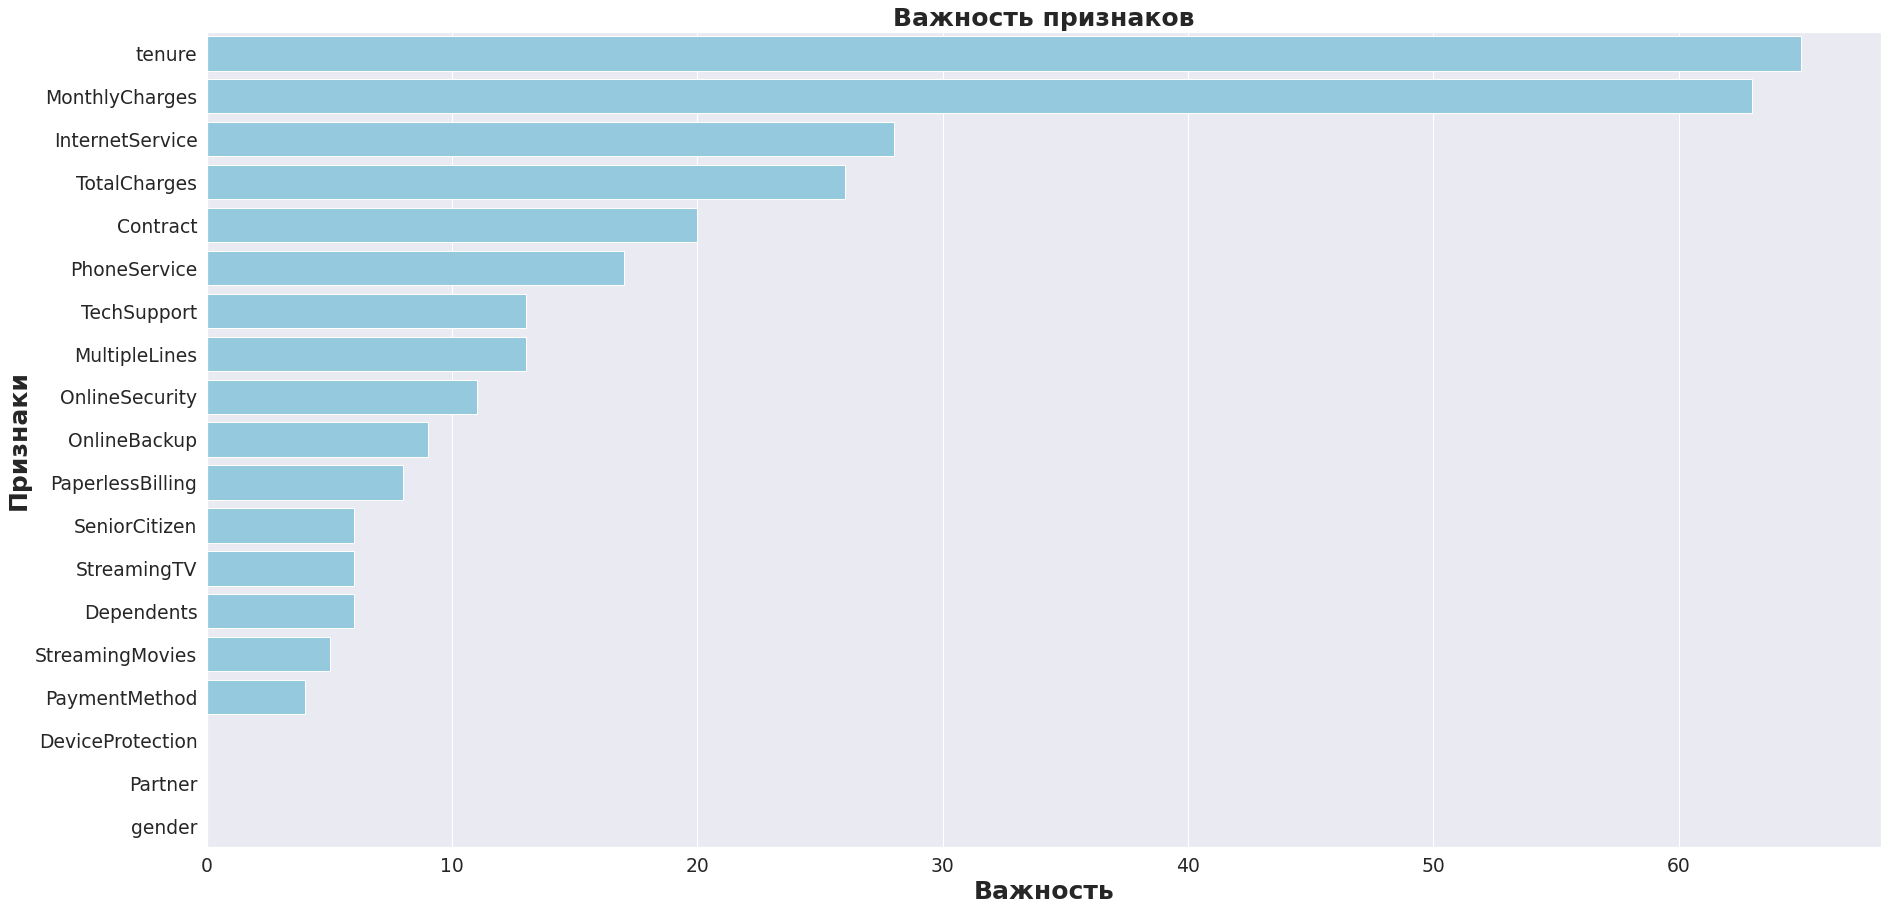

None

,Features,Gini-Importance
0,tenure,65
1,MonthlyCharges,63
2,InternetService,28
3,TotalCharges,26
4,Contract,20
5,PhoneService,17
6,TechSupport,13
7,MultipleLines,13
8,OnlineSecurity,11
9,OnlineBackup,9


In [48]:
feature_importance(lgbm_clf_fitted)

**Лучшие гиперпараметры:**

* {'l2_leaf_reg': 1, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}

**Метрики:**

* Accuracy: 0.795
* Presicion: 0.64
* Recall: 0.527
* AUC-ROC: 0.84


**Топ-5 важных признаков модели:**

* tenure
* MonthlyCharges
* InternetService	
* TotalCharges
* Contract

**По моделям градиентного бустинга можно сказать:**

* качество по интересующим метрикам примерно одинаковое
  * Accuracy примерно: 0.79
  * AUC-ROC примерно: 0.84
* скорость обучения
  * CatBoost и XGBoost самое долгое, 15 мин и 12 мин соответственно
  * LGBM значительно быстрее обучается на этих данных - всего 2 мин.

In [53]:
data = {'Модель':['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier', 'XGBClassifier', 'LGBMClassifier'], 
        'Presicion': [0.636, 0.65, 0.667, 0.648, 0.64],
        'Recall': [0.561, 0.516, 0.481, 0.532, 0.527],
        'Accuracy':[0.798, 0.797, 0.798, 0.799, 0.795],
        'AUC-ROC': [0.837, 0.836, 0.84, 0.84, 0.84],
        'Скорость обучения': ['4.17s', '1min 27s', '15min 23s', '11min 57s', '2min 44s']}

pd.DataFrame(data)

,Модель,Presicion,Recall,Accuracy,AUC-ROC,Скорость обучения
0,LogisticRegression,0.636,0.561,0.798,0.837,4.17s
1,RandomForestClassifier,0.650,0.516,0.797,0.836,1min 27s
2,CatBoostClassifier,0.667,0.481,0.798,0.840,15min 23s
3,XGBClassifier,0.648,0.532,0.799,0.840,11min 57s
4,LGBMClassifier,0.640,0.527,0.795,0.840,2min 44s


* ROC-кривая (или кривая ошибок) изображается в осях: по горизонтали доля ложноположительных ответов (FPR), а по вертикали — доля истинно положительных ответов (TPR). Чем график выше, тем больше значение TPR и лучше качество модели.
* Accuracy показывает как часто модель ошибается
* Полнота выявляет, какую долю положительных среди всех ответов выделила модель.
* Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные.

> 1. Логистическая регрессия уступает по интересующим метрикам качества (Accuracy, AUC-ROC) другим моделям с лесами, но выигрывает сильно во времени обучения
> 2. Случайный лес немного лучше, но дольше обучается, особенно когда много деревьев
> 3. Лучшие по качеству метрик модели градиентного бустинга, но у этого есть обратная сторона - долгое время обучения.
> 4. Лучшая модель по оценкам интересующих метрик - LGBM
> 5. Большинство моделей определило следующие признаки наиболее значимыми:
  - tenure   
  - MonthlyCharges 
  - Contract
  - InternetService

## Вывод
 Исследовательский анализ данных позволил определить группы пользователей, которые склонны к уходу. Даже без машинного обучения можно сформировать портреты лояльных и нелояльных клиентов и предпринять упреждающие событию действия, направленые на удержание клиента

Машинное обучение позволяет видеть метрики вероятности ухода клиента. В нашем случае у моделей:
* Accuracy примерно: 0.795
* AUC-ROC примерно: 0.84
* То есть с вероятностью 79.5% модели могут дать правильный прогноз


Лучшая модель по указанным метрикам и скорости обучения - LGBM.
Модель показала на тестовой выборке:
Accuracy: 0.795
AUC-ROC: 0.84


### P.S.

Было выяснено, что если непосредственно перед обучением моделей произвести: 
* **Категориальеные признаки перевели в численные через One-Hot Encoding, количественные нормировали через StandardScaler**

и добавить еще несколько признаков например:

* constant_person - постоянные люди, они оплачивают счета на 1, 2 года вперед
* vip_client - клиенты, тратящие больше 3 квантиля по месячным отчислениям и длительностью контракта больше 1 года.

то метрики качества улучшаются!